# Prueba del dataset con BERT

In [1]:
# --- INSTALAR NLTK DESDE EL KERNEL ACTIVO SI FALTA ---
import sys
try:
    import nltk
except ImportError:
    !{sys.executable} -m pip install nltk
    import nltk

# --- IGNORA ADVERTENCIAS DE PYTHON PARA SECURIZAR RUTAS ---
import warnings
warnings.filterwarnings('ignore')

# --- DESCARGAR STOPWORDS ---
nltk.download('stopwords', quiet=True)

import string
import pandas as pd
from nltk.corpus import stopwords

# --- CONFIGURAR STOPWORDS EN INGLÉS ---
stop_words = set(stopwords.words("english"))

# --- FUNCION DE LIMPIEZA DE TEXTO ---
def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    tokens = texto.split()
    tokens_filtrados = [word for word in tokens if word not in stop_words]
    return " ".join(tokens_filtrados)

# --- CARGAR CSV DE ENTRENAMIENTO ---
df_train = pd.read_csv("pan12-sexual-predator-identification-training-corpus-2012-05-01.csv")

# --- CARGAR LISTA DE AUTORES DEPREDADORES ---
with open("pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt", "r") as f:
    lista_predators = f.read().splitlines()

# --- CREAR COLUMNA DE CLASE (1 = DEPREDADOR, 0 = NO) ---
df_train["clase"] = df_train["autor"].apply(lambda x: 1 if str(x) in lista_predators else 0)

# --- LIMPIAR LOS MENSAJES ---
df_train["mensaje_procesado"] = df_train["mensaje"].apply(limpiar_texto)

# --- MOSTRAR RESULTADO ---
print("Dataset cargado y procesado correctamente")
print(df_train[["autor", "mensaje", "mensaje_procesado", "clase"]].head())


Dataset cargado y procesado correctamente
                              autor     mensaje mensaje_procesado  clase
0  97964e7a9e8eb9cf78f2e4d7b2ff34c7       Hola.              hola      0
1  0158d0d6781fc4d493f243d4caa49747         hi.                hi      0
2  0158d0d6781fc4d493f243d4caa49747   whats up?             whats      0
3  97964e7a9e8eb9cf78f2e4d7b2ff34c7  not a ton.               ton      0
4  97964e7a9e8eb9cf78f2e4d7b2ff34c7        you?                        0


In [2]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# --- TOMAMOS UNA MUESTRA REDUCIDA PARA ENTRENAMIENTO ---
df_muestra = df_train[["mensaje_procesado", "clase"]].sample(5000, random_state=42).reset_index(drop=True)

# --- RENAME PARA QUE FUNCIONE CON HUGGING FACE ---
df_muestra.rename(columns={"mensaje_procesado": "text", "clase": "label"}, inplace=True)

# --- DIVIDIR EN TRAIN Y VALIDACIÓN ---
train_df, val_df = train_test_split(df_muestra, test_size=0.2, stratify=df_muestra["label"], random_state=42)

# --- CONVERTIR A DATASET DE HUGGING FACE ---
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# --- TOKENIZADOR BERT ---
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# --- MODELO BERT PARA CLASIFICACIÓN BINARIA ---
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# --- ARGUMENTOS DE ENTRENAMIENTO ---
training_args = TrainingArguments(
    output_dir="./results_bert",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10
)

# --- TRAINER ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# --- ENTRENAR EL MODELO ---
trainer.train()

# --- EVALUACIÓN FINAL ---
preds_output = trainer.predict(val_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = val_dataset["label"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_true, y_pred))


Map: 100%|██████████| 1000/1000 [00:00<00:00, 18391.47 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.459100
20,0.202400
30,0.236600
40,0.285900
50,0.218700
60,0.138900
70,0.072200
80,0.267800
90,0.115100
100,0.074000


Accuracy: 0.953

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       952
           1       0.60      0.06      0.11        48

    accuracy                           0.95      1000
   macro avg       0.78      0.53      0.54      1000
weighted avg       0.94      0.95      0.93      1000



,modelo,accuracy,recall_clase_1,f1_clase_1
0,Naive Bayes,0.954997,0.015997,0.031209
1,SVM,0.955141,0.018806,0.036601
2,Random Forest,0.954366,0.055929,0.099967
3,BERT,0.950000,0.083333,0.137931


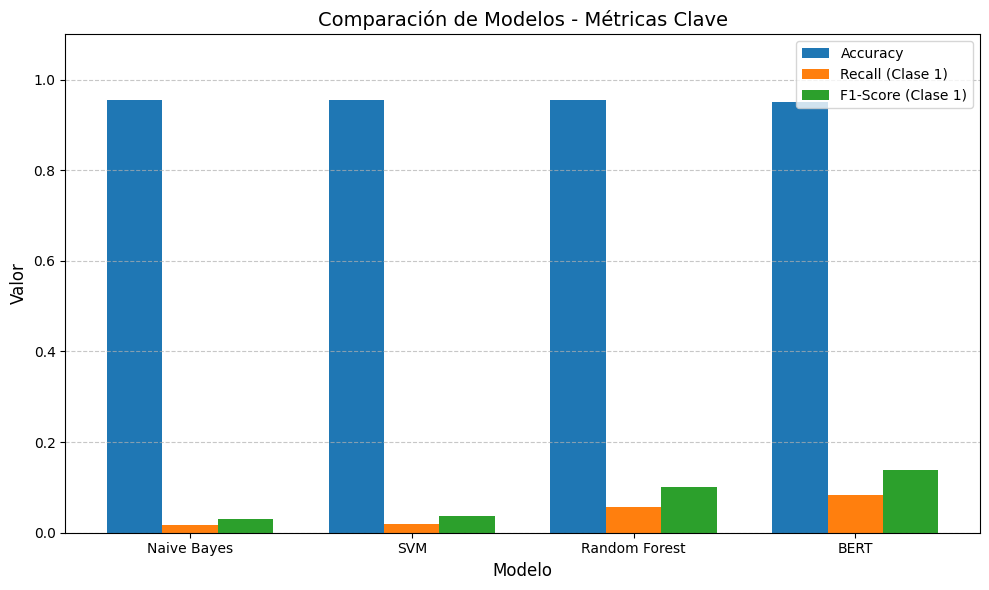

In [3]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as display_module


# Cargar archivo final con los 4 modelos
df_resultados = pd.read_csv("resultados_modelos_comparados.csv")

# Mostrar la tabla
display_module.display(df_resultados)

# Crear gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
x = range(len(df_resultados["modelo"]))
width = 0.25

plt.bar([i - width for i in x], df_resultados["accuracy"], width=width, label="Accuracy")
plt.bar(x, df_resultados["recall_clase_1"], width=width, label="Recall (Clase 1)")
plt.bar([i + width for i in x], df_resultados["f1_clase_1"], width=width, label="F1-Score (Clase 1)")

plt.xticks(ticks=x, labels=df_resultados["modelo"])
plt.title("Comparación de Modelos - Métricas Clave", fontsize=14)
plt.ylabel("Valor", fontsize=12)
plt.xlabel("Modelo", fontsize=12)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [5]:
# --- Cargar el CSV de test (ajusta el nombre si es diferente) ---
df_test = pd.read_csv("pan12-sexual-predator-identification-test-corpus-2012-05-17.csv")

# --- Tomar muestra reducida de 5.000 mensajes ---
df_test_sample = df_test.sample(5000, random_state=42).reset_index(drop=True)


# --- Limpieza de texto ---
stop_words = set(stopwords.words("english"))

def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    tokens = texto.split()
    tokens_filtrados = [word for word in tokens if word not in stop_words]
    return " ".join(tokens_filtrados)

df_test_sample["mensaje_procesado"] = df_test_sample["mensaje"].apply(limpiar_texto)

# --- Tokenizar con el tokenizer de BERT ---
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

ds_test = Dataset.from_pandas(df_test_sample[["mensaje_procesado"]].rename(columns={"mensaje_procesado": "text"}))
ds_test = ds_test.map(lambda e: tokenizer(e["text"], padding=True, truncation=True, max_length=128), batched=True)

# --- Predecir con el modelo BERT ya entrenado ---
predicciones = trainer.predict(ds_test)
y_pred_test = predicciones.predictions.argmax(axis=1)

# --- Añadir las predicciones a la muestra del test ---
df_test_sample["prediccion_bert"] = y_pred_test

# --- Mostrar algunos ejemplos clasificados como sospechosos ---
ejemplos_sospechosos = df_test_sample[df_test_sample["prediccion_bert"] == 1].sample(20, random_state=42)
display(ejemplos_sospechosos[["autor", "mensaje", "prediccion_bert"]])

# --- Guardar resultados para revisión externa ---
df_test_sample.to_csv("resultados_test_BERT_sample.csv", index=False)
print("Resultados guardados como 'resultados_test_BERT_sample.csv'")


Map: 100%|██████████| 5000/5000 [00:01<00:00, 3813.59 examples/s]


,autor,mensaje,prediccion_bert
4631,f5231a4bd4c29f4d613b450ba123162e,u think all we will ever do is just talk?,1
2642,68e88c75d75c09f0d45d6e9a75e9ddfb,i want u,1
2270,815de8eb13c20cc0ff35384abac6cad2,ok u?,1
3934,19c5f12c1d14104464f73a3ebe732926,how U GOING?,1
977,ca01f49c85d74e87fbaddbb693caad24,i am very happy that u was here till now,1
1907,c00da33100124ca45bea05303d7122f0,ye but y do u care?,1
3517,eef5ce716eb6cbc001d190a9791f9cbd,please say that u have,1
256,fe784e376f0fec7691b114f16d7f953e,did u do anything exciting?,1
4459,af31b3a71f7e0acc4aecd0929da08e3b,i dont get it,1
2461,656c33d8220f63a31e46081ff70bc63a,i would do u,1


Resultados guardados como 'resultados_test_BERT_sample.csv'
